In [1]:
from dataset import MAESTRO
from torch.utils.data import Dataset, DataLoader
from model_nms_latent import *
from nnAudio import Spectrogram
import torch
from torch.distributions import kl_divergence
from torch import optim
from sklearn.metrics import accuracy_score
import json, os
import datetime
from tqdm import tqdm
import librosa
from IPython.display import Audio

In [4]:
with open('nms_latent_config.json') as f:
    args = json.load(f)
model_path = 'params/' + os.listdir('params/')[-1]

# train_ds = MAESTRO(path='/data/MAESTRO', groups=['train'], sequence_length=320000)
# train_dl = DataLoader(train_ds, batch_size=args["batch_size"], shuffle=False, num_workers=0)
# test_ds = MAESTRO(path='/data/MAESTRO', groups=['test'], sequence_length=320000)
# test_dl = DataLoader(test_ds, batch_size=args["batch_size"], shuffle=False, num_workers=0)

# train_emotion_ds = MAESTRO(path='/data/MAESTRO', groups=['train_emotion'], sequence_length=320000)
# train_emotion_dl = DataLoader(train_emotion_ds, batch_size=args["batch_size"], shuffle=False, num_workers=0)
# test_emotion_ds = MAESTRO(path='/data/MAESTRO', groups=['test_emotion'], sequence_length=320000)
# test_emotion_dl = DataLoader(test_emotion_ds, batch_size=args["batch_size"], shuffle=False, num_workers=0)

# s_percent, u_percent = str(args["percent"]), str(100 - args["percent"])
# # load unlabelled data
# train_ds = MAESTRO(path='/data/MAESTRO', groups=['train_u_{}'.format(u_percent)], sequence_length=320000)
# train_dl = DataLoader(train_ds, batch_size=args["batch_size"], shuffle=True, num_workers=0)
# val_ds = MAESTRO(path='/data/MAESTRO', groups=['validation_u_{}'.format(u_percent)], sequence_length=320000)
# val_dl = DataLoader(val_ds, batch_size=args["batch_size"], shuffle=False, num_workers=0)
# test_ds = MAESTRO(path='/data/MAESTRO', groups=['test_u_{}'.format(u_percent)], sequence_length=320000)
# test_dl = DataLoader(test_ds, batch_size=args["batch_size"], shuffle=False, num_workers=0)

# load labelled data
# print("Loading performance style dict...", end="\r")
# with open("data/performance_style_dict_v2.json", "r+") as f:
#     performance_style_dict = json.load(f)
# print("Loading performance style dict...done.")
    
train_s_ds = MAESTRO(path='/data/MAESTRO', groups=['train_s'], sequence_length=320000,
                performance_style_dict=None)
train_s_dl = DataLoader(train_s_ds, batch_size=args["batch_size"], shuffle=True, num_workers=0)
val_s_ds = MAESTRO(path='/data/MAESTRO', groups=['validation_s'], sequence_length=320000,
            performance_style_dict=None)
val_s_dl = DataLoader(val_s_ds, batch_size=args["batch_size"], shuffle=False, num_workers=0)
test_s_ds = MAESTRO(path='/data/MAESTRO', groups=['test_s'], sequence_length=320000,
            performance_style_dict=None)
test_s_dl = DataLoader(test_s_ds, batch_size=args["batch_size"], shuffle=False, num_workers=0)

Loading group test_s: 100%|██████████| 178/178 [00:02<00:00, 82.63it/s]


In [ ]:
cls_lst_art = []
cls_lst_dyn = []
for i, x in enumerate(train_s_dl):
    audio, onset_pr, frame_pr, cls = x     # (b, 320000), (b, t=625, 88)
    cls_lst_art.append(cls[0])
    cls_lst_dyn.append(cls[1])

cls_lst_art = torch.cat(cls_lst_art, dim=0)
cls_lst_dyn = torch.cat(cls_lst_dyn, dim=0)
from collections import Counter
print("Supervised actual labels:", Counter(cls_lst_art.cpu().numpy()), Counter(cls_lst_dyn.cpu().numpy()))

In [5]:
from trainer_nms_latent import Normalizer
normalizer = Normalizer(mode="imagewise")

In [6]:
model = NMSLatentDisentangledDynamic(n_component=2)
model.cuda()
model.load_state_dict(torch.load("params/recon_nms_latent_20200603-111934.pt_log-minmax_25"))

<All keys matched successfully>

In [7]:
wav_to_melspec = Spectrogram.MelSpectrogram(sr=16000, n_mels=80)

STFT filter created, time used = 0.0020 seconds
Mel filter created, time used = 0.0021 seconds


In [34]:
import matplotlib.pyplot as plt

from trainer_recon import Normalizer
normalizer = Normalizer(mode="imagewise")

audio, onset_pr, frame_pr, label = test_s_ds[52]     # (b, 320000), (b, t=625, 88)
pr_visualize = onset_pr + frame_pr
Audio(audio.cpu().detach().numpy(), rate=16000)


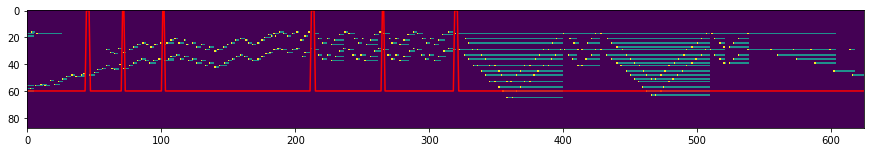

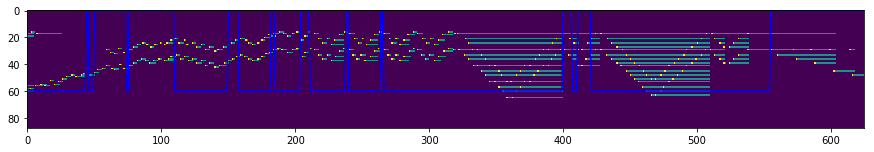

In [35]:
import matplotlib.pyplot as plt
melspec = torch.transpose(wav_to_melspec(audio), 1, 2)[:, :-1, :]   # (b, 625, 128)
melspec_original = wav_to_melspec(audio)
plt.figure(figsize=(15,15))
pr_visualize = onset_pr + frame_pr
plt.imshow(pr_visualize.cpu().numpy().squeeze().T)
plt.plot(label[0] * 60, color='red')
plt.show()
plt.figure(figsize=(15,15))
pr_visualize = onset_pr + frame_pr
plt.imshow(pr_visualize.cpu().numpy().squeeze().T)
plt.plot(label[1] * 60, color='blue')
plt.show()

In [29]:
pr = onset_pr
melspec = torch.transpose(wav_to_melspec(audio), 1, 2)[:, :-1, :]   # (b, 625, 128)
melspec_original = wav_to_melspec(audio)

# use log melspec
pr = pr.cuda().unsqueeze(0)
melspec = normalizer.transform(torch.log(melspec + 1e-12)).cuda()

melspec_hat, z_art_lst, art_cls_lst, mu_art_lst, var_art_lst,\
                     z_dyn_lst, dyn_cls_lst, mu_dyn_lst, var_dyn_lst = model(melspec, pr)

melspec_hat_denorm = torch.exp(melspec_hat * (10 + 20) - 20).T.squeeze()

# conditional generation
def repar(mu, stddev, sigma=1):
    eps = Normal(0, sigma).sample(sample_shape=stddev.size()).cuda()
    z = mu + stddev * eps  # reparameterization trick
    return z

In [30]:
model.eval()
mu, var = model.mu_art_lookup(torch.Tensor([0]).long().cuda()), model.logvar_art_lookup(torch.Tensor([0]).long().cuda()).exp_()
z_art_0 = repar(mu, var)
mu, var = model.mu_art_lookup(torch.Tensor([1]).long().cuda()), model.logvar_art_lookup(torch.Tensor([1]).long().cuda()).exp_()
z_art_1 = repar(mu, var)
mu, var = model.mu_dyn_lookup(torch.Tensor([0]).long().cuda()), model.logvar_dyn_lookup(torch.Tensor([0]).long().cuda()).exp_()
z_dyn_0 = repar(mu, var)
mu, var = model.mu_dyn_lookup(torch.Tensor([1]).long().cuda()), model.logvar_dyn_lookup(torch.Tensor([1]).long().cuda()).exp_()
z_dyn_1 = repar(mu, var)

print(torch.max(z_art_0), torch.min(z_art_0))
print(torch.max(z_art_1), torch.min(z_art_1))
print(torch.max(z_dyn_0), torch.min(z_dyn_0))
print(torch.max(z_dyn_1), torch.min(z_dyn_1))

tensor(0.2046, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.2078, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.2138, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.2405, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.1636, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.1369, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.1848, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.1398, device='cuda:0', grad_fn=<MinBackward1>)


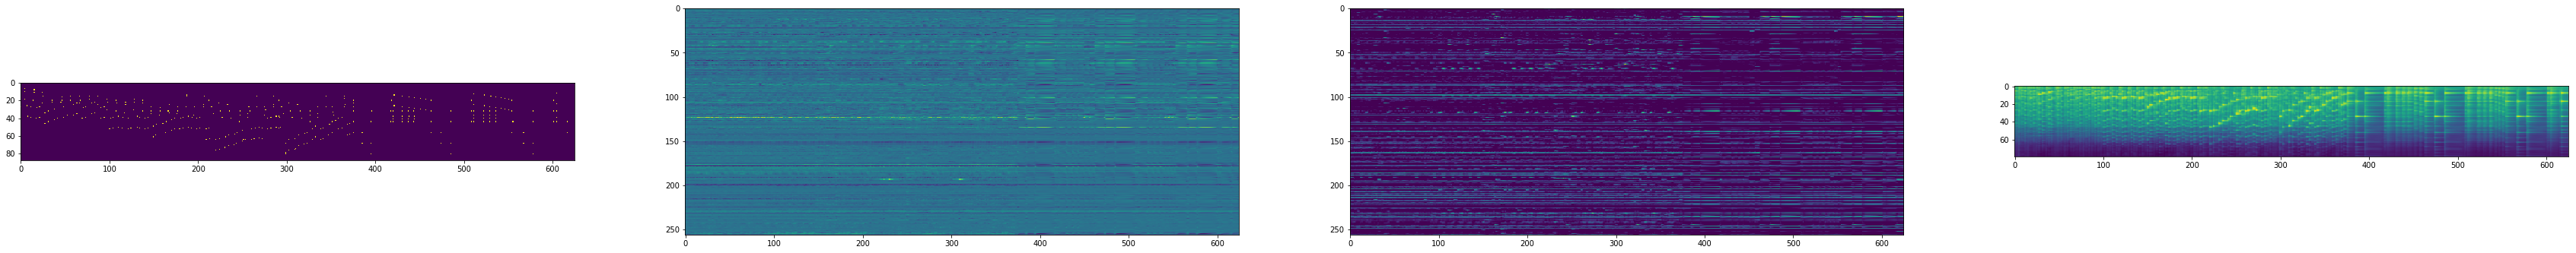

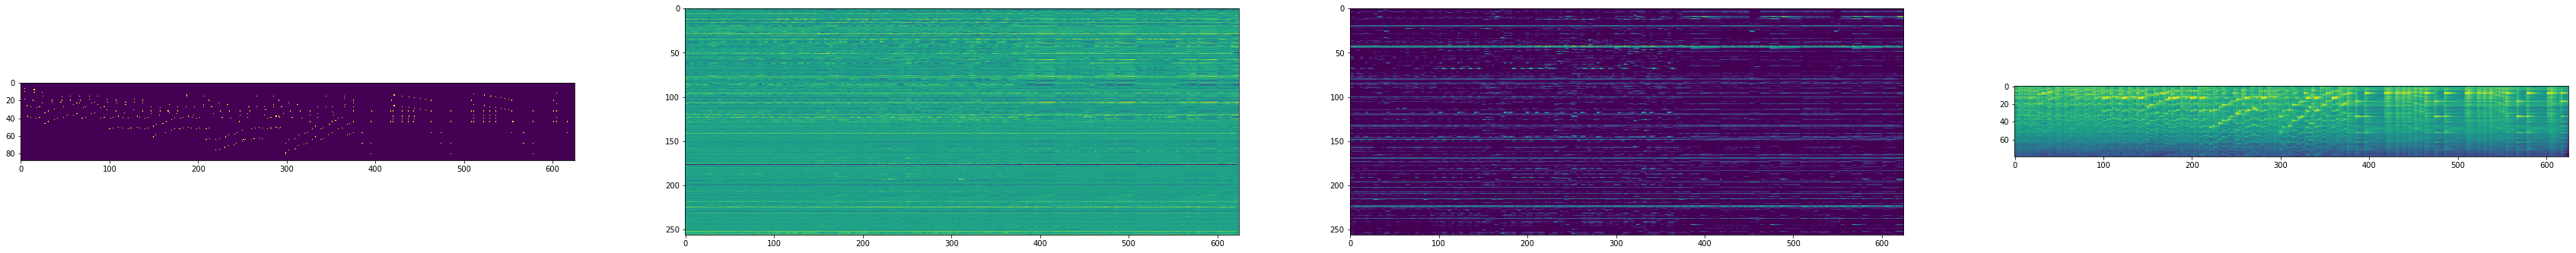

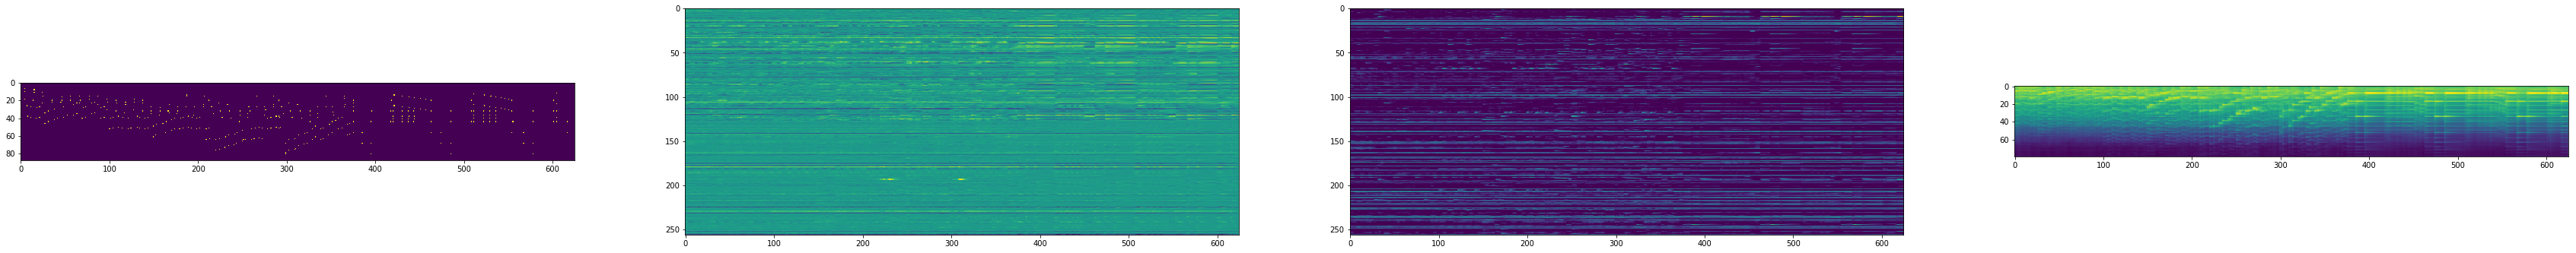

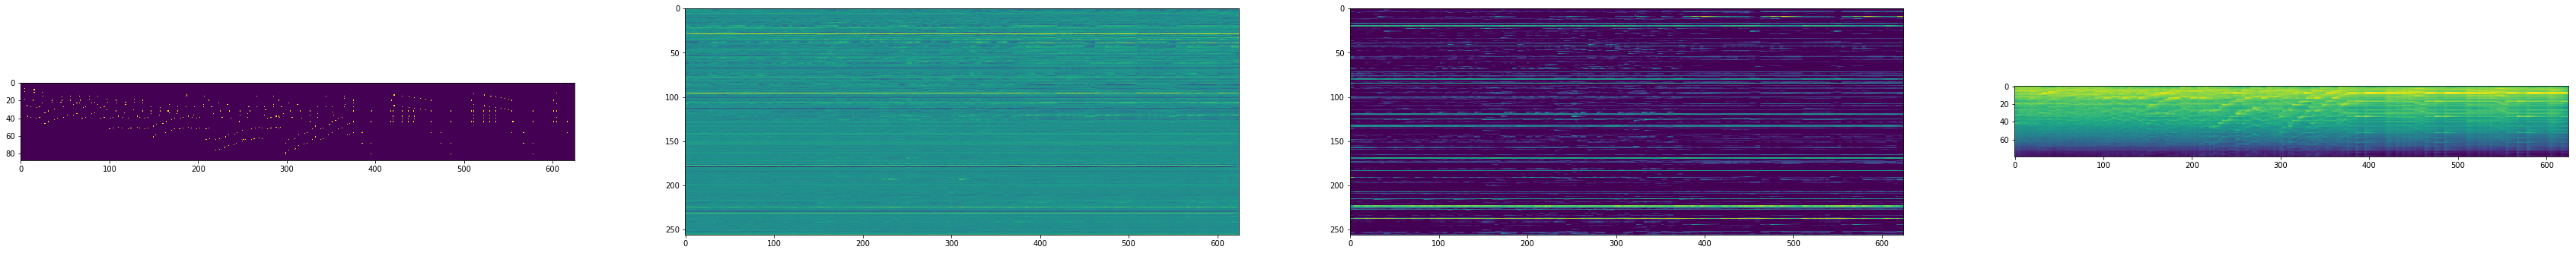

In [36]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(60, 60))

ax1.imshow(pr.squeeze().cpu().detach().numpy().T)

z_art_0_lst = torch.stack([z_art_0] * 625, dim=1)
z_art_1_lst = torch.stack([z_art_1] * 625, dim=1)
z_dyn_0_lst = torch.stack([z_dyn_0] * 625, dim=1)
z_dyn_1_lst = torch.stack([z_dyn_1] * 625, dim=1)

z_distribute = torch.cat([z_art_0_lst, z_dyn_0_lst], dim=-1)
decoder_features = torch.cat([pr, z_distribute], dim=-1)
x_hat = model.bilstm(decoder_features)[0]
ax2.imshow(x_hat.squeeze().cpu().detach().numpy().T)
x_hat = torch.transpose(x_hat, 1,2)
x_hat = x_hat.unsqueeze(-1)
x_hat = nn.ReLU()(model.out_conv(x_hat))
ax3.imshow(x_hat.squeeze().cpu().detach().numpy())
x_hat = nn.Sigmoid()(model.out_conv_2(x_hat))
ax4.imshow(x_hat.squeeze().cpu().detach().numpy())
x_hat = x_hat.squeeze(-1)
x_hat_1 = torch.transpose(x_hat, 1,2)

x_hat_out = (x_hat_1 * (10 + 20) - 20).T.squeeze()
x_hat_denorm = torch.exp(x_hat_1 * (10 + 20) - 20).T.squeeze()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(60, 60))

ax1.imshow(pr.squeeze().cpu().detach().numpy().T)

z_distribute = torch.cat([z_art_0_lst, z_dyn_1_lst], dim=-1)
decoder_features = torch.cat([pr, z_distribute], dim=-1)
x_hat = model.bilstm(decoder_features)[0]
ax2.imshow(x_hat.squeeze().cpu().detach().numpy().T)
x_hat = torch.transpose(x_hat, 1,2)
x_hat = x_hat.unsqueeze(-1)
x_hat = nn.ReLU()(model.out_conv(x_hat))
ax3.imshow(x_hat.squeeze().cpu().detach().numpy())
x_hat = nn.Sigmoid()(model.out_conv_2(x_hat))
ax4.imshow(x_hat.squeeze().cpu().detach().numpy())
x_hat = x_hat.squeeze(-1)
x_hat_2 = torch.transpose(x_hat, 1,2)
# ax3.imshow(x_hat_2.squeeze().cpu().detach().numpy().T)

x_hat_out_2 = (x_hat_2 * (10 + 20) - 20).T.squeeze()
x_hat_denorm_2 = torch.exp(x_hat_2 * (10 + 20) - 20).T.squeeze()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(60, 60))

ax1.imshow(pr.squeeze().cpu().detach().numpy().T)

z_distribute = torch.cat([z_art_1_lst, z_dyn_0_lst], dim=-1)
decoder_features = torch.cat([pr, z_distribute], dim=-1)
x_hat = model.bilstm(decoder_features)[0]
ax2.imshow(x_hat.squeeze().cpu().detach().numpy().T)
x_hat = torch.transpose(x_hat, 1,2)
x_hat = x_hat.unsqueeze(-1)
x_hat = nn.ReLU()(model.out_conv(x_hat))
ax3.imshow(x_hat.squeeze().cpu().detach().numpy())
x_hat = nn.Sigmoid()(model.out_conv_2(x_hat))
ax4.imshow(x_hat.squeeze().cpu().detach().numpy())
x_hat = x_hat.squeeze(-1)
x_hat_3 = torch.transpose(x_hat, 1,2)
# ax3.imshow(x_hat_3.squeeze().cpu().detach().numpy().T)

x_hat_out_3 = (x_hat_3 * (10 + 20) - 20).T.squeeze()
x_hat_denorm_3 = torch.exp(x_hat_3 * (10 + 20) - 20).T.squeeze()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(60, 60))

ax1.imshow(pr.squeeze().cpu().detach().numpy().T)

z_distribute = torch.cat([z_art_1_lst, z_dyn_1_lst], dim=-1)
decoder_features = torch.cat([pr, z_distribute], dim=-1)
x_hat = model.bilstm(decoder_features)[0]
ax2.imshow(x_hat.squeeze().cpu().detach().numpy().T)
x_hat = torch.transpose(x_hat, 1,2)
x_hat = x_hat.unsqueeze(-1)
x_hat = nn.ReLU()(model.out_conv(x_hat))
ax3.imshow(x_hat.squeeze().cpu().detach().numpy())
x_hat = nn.Sigmoid()(model.out_conv_2(x_hat))
ax4.imshow(x_hat.squeeze().cpu().detach().numpy())
x_hat = x_hat.squeeze(-1)
x_hat_4 = torch.transpose(x_hat, 1,2)

x_hat_out_4 = (x_hat_4 * (10 + 20) - 20).T.squeeze()
x_hat_denorm_4 = torch.exp(x_hat_4 * (10 + 20) - 20).T.squeeze()

pr_visualize = onset_pr + frame_pr

In [32]:
np.save("temp_1.npy", x_hat_out.cpu().detach().numpy())
np.save("temp_2.npy", x_hat_out_2.cpu().detach().numpy())
np.save("temp_3.npy", x_hat_out_3.cpu().detach().numpy())
np.save("temp_4.npy", x_hat_out_4.cpu().detach().numpy())

In [37]:
print(torch.max(x_hat_denorm), torch.min(x_hat_denorm))
print(torch.max(x_hat_denorm_2), torch.min(x_hat_denorm_2))
print(torch.max(x_hat_denorm_3), torch.min(x_hat_denorm_3))
print(torch.max(x_hat_denorm_4), torch.min(x_hat_denorm_4))

tensor(6.0402, device='cuda:0', grad_fn=<MaxBackward1>) tensor(6.8548e-08, device='cuda:0', grad_fn=<MinBackward1>)
tensor(50.9602, device='cuda:0', grad_fn=<MaxBackward1>) tensor(7.5843e-06, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.1641, device='cuda:0', grad_fn=<MaxBackward1>) tensor(1.2136e-07, device='cuda:0', grad_fn=<MinBackward1>)
tensor(360.0297, device='cuda:0', grad_fn=<MaxBackward1>) tensor(3.9896e-06, device='cuda:0', grad_fn=<MinBackward1>)


In [ ]:
rotated = np.flipud(x_hat_4.cpu().detach().numpy().squeeze().T)
plt.figure(figsize=(15,15))
plt.imshow(rotated)
plt.show()

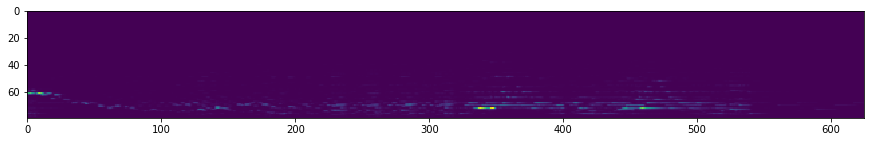

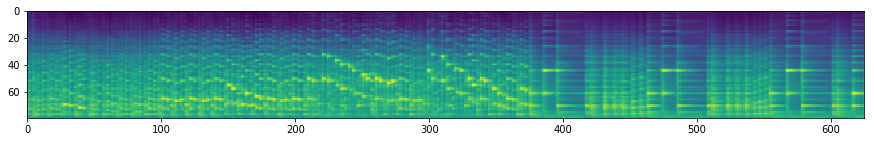

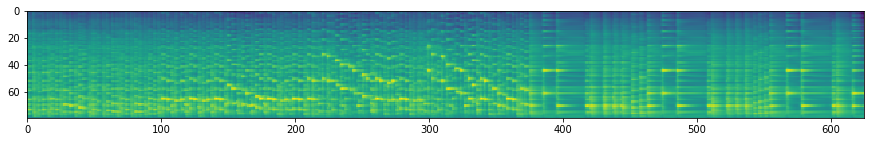

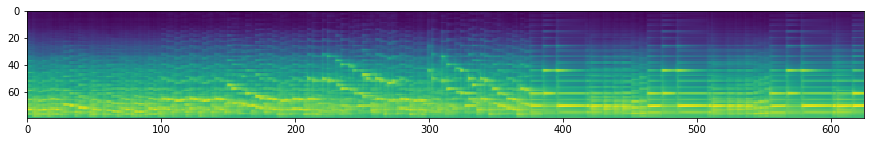

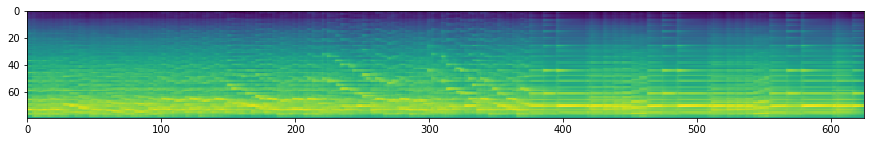

In [38]:
plt.figure(figsize=(15,15))
rotated = np.flipud(melspec.cpu().detach().numpy().squeeze().T)
plt.imshow(rotated)
plt.show()
plt.figure(figsize=(15,15))
rotated = np.flipud(x_hat_1.cpu().detach().numpy().squeeze().T)
plt.imshow(rotated)
plt.show()
plt.figure(figsize=(15,15))
rotated = np.flipud(x_hat_2.cpu().detach().numpy().squeeze().T)
plt.imshow(rotated)
plt.show()
plt.figure(figsize=(15,15))
rotated = np.flipud(x_hat_3.cpu().detach().numpy().squeeze().T)
plt.imshow(rotated)
plt.show()
plt.figure(figsize=(15,15))
rotated = np.flipud(x_hat_4.cpu().detach().numpy().squeeze().T)
plt.imshow(rotated)
plt.show()

In [ ]:
# temporary block
cls_lst_temp = []
for i in tqdm(range(len(train_ds))):
    audio, onset_pr, frame_pr = train_ds[i]     # (b, 320000), (b, t=625, 88)
    pr = torch.cat([onset_pr, frame_pr], dim=-1)
    melspec = torch.transpose(wav_to_melspec(audio), 1, 2)[:, :-1, :]   # (b, 625, 128)
    melspec_original = wav_to_melspec(audio)

    # use log melspec
    pr = pr.cuda().unsqueeze(0)
    melspec = normalizer.transform(torch.log(melspec + 1e-12)).cuda()
    melspec_hat, z, cls_z_logits, cls_z_prob, z_dist = model(melspec, pr)
    cls_lst_temp.append(torch.argmax(cls_z_prob, dim=-1).cpu().detach().item())

from collections import Counter
print(Counter(cls_lst_temp))


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(pr_visualize.cpu().detach().numpy().squeeze().T)
plt.show()
print(label)

In [ ]:
from IPython.display import Audio
Audio(audio.cpu().numpy(), rate=16000)

In [ ]:
plt.figure(figsize=(8, 4))
plt.imshow(melspec.cpu().detach().numpy().squeeze().T)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(8, 4))
melspec_db_1 = librosa.power_to_db(x_hat_denorm.cpu().detach().numpy().squeeze(), ref=np.max)

librosa.display.specshow(melspec_db_1, x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000)
plt.colorbar(format='%+2.0f dB')

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(8, 4))
print(melspec_hat_denorm.shape)
melspec_db_2 = librosa.power_to_db(x_hat_denorm_2.cpu().detach().numpy().squeeze(), ref=np.max)
librosa.display.specshow(melspec_db_2, x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000)
plt.colorbar(format='%+2.0f dB')

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(8, 4))
print(melspec_hat_denorm.shape)
melspec_db_3 = librosa.power_to_db(x_hat_denorm_3.cpu().detach().numpy().squeeze(), ref=np.max)
librosa.display.specshow(melspec_db_3, x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000)
plt.colorbar(format='%+2.0f dB')

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(8, 4))
print(melspec_hat_denorm.shape)
melspec_db_2 = librosa.power_to_db(x_hat_denorm_4.cpu().detach().numpy().squeeze(), ref=np.max)
librosa.display.specshow(melspec_db_2, x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000)
plt.colorbar(format='%+2.0f dB')

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(8, 4))
print(melspec_hat_denorm.shape)
melspec_db_2 = librosa.power_to_db(melspec_original.cpu().detach().numpy().squeeze(), ref=np.max)
librosa.display.specshow(melspec_db_2, x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000)
plt.colorbar(format='%+2.0f dB')

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(8, 4))
print(melspec_hat_denorm.shape)
melspec_db_2 = librosa.power_to_db(melspec_hat_denorm.cpu().detach().numpy().squeeze(), ref=np.max)
librosa.display.specshow(melspec_db_2, x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000)
plt.colorbar(format='%+2.0f dB')

In [ ]:
filter_banks = torch.from_numpy(mel(16000, windowsize)).cuda()
print(filter_banks.shape)

N_CHANNELS = 128
N_FFT = 2048
a = np.zeros_like(x_hat_denorm_2.cpu().detach().numpy())
a[:N_CHANNELS,:] = x_hat_denorm_2.cpu().detach().numpy()
a_spec = np.matmul(filter_banks.cpu().numpy().T, a)

# This code is supposed to do phase reconstruction

p = 2 * np.pi * np.random.random_sample(a_spec.shape) - np.pi
for i in tqdm(range(500)):
    S = a_spec * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

print(x.shape)

In [ ]:
Audio(x, rate=16000)

In [ ]:
from torch.optim.lbfgs import LBFGS
from torch.optim import Adam

def L_BFGS(spec, transform_fn, samples=None, init_x0=None, maxiter=1000, tol=1e-8, verbose=1, evaiter=10, metric='sc',
           **kwargs):
    
    if init_x0 is None:
        init_x0 = spec.new_empty(samples).normal_(std=1e-5)
    x = nn.Parameter(init_x0)
    T = spec

    criterion = nn.MSELoss()
#     optimizer = LBFGS([x], **kwargs)
    optimizer = Adam([x], lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

    def closure():
        optimizer.zero_grad()
        V = transform_fn(x)
        loss = criterion(V, T)
        loss.backward()
        return loss

    bar_dict = {}
    if metric == 'snr':
        metric_func = SNR
        bar_dict['SNR'] = 0
        metric = metric.upper()
    elif metric == 'ser':
        metric_func = SER
        bar_dict['SER'] = 0
        metric = metric.upper()
    else:
        pass

    init_loss = None
    with tqdm(total=maxiter, disable=not verbose) as pbar:
        for i in range(maxiter):
            optimizer.step(closure)

            if i % evaiter == evaiter - 1:
                with torch.no_grad():
                    V = transform_fn(x)
                    l2_loss = criterion(V, spec).item()
                    pbar.set_postfix(**bar_dict, loss=l2_loss)
                    pbar.update(evaiter)

                    if not init_loss:
                        init_loss = l2_loss
                    elif (previous_loss - l2_loss) / init_loss < tol * evaiter:
                        break
                    previous_loss = l2_loss

    return x.detach()


In [ ]:
print(torch.max(x_hat_denorm))
np.save("temp_1.npy", x_hat_denorm.cpu().detach().numpy())
print(x_hat_denorm.shape)

In [ ]:
from librosa.filters import mel

windowsize = 2048
window = torch.hann_window(windowsize).cuda()
filter_banks = torch.from_numpy(mel(16000, windowsize, n_mels=80)).cuda()
print(filter_banks.shape)

def trsfn(x):
    S = torch.stft(x, windowsize, window=window).pow(2).sum(2).sqrt() ** 2.0
    mel_S = filter_banks @ S
    return mel_S

melspec_hat_denorm_temp = torch.cat([x_hat_denorm_3.squeeze(), torch.zeros(80).cuda().unsqueeze(-1)], dim=-1).detach()
yhat = L_BFGS(melspec_hat_denorm_temp, trsfn, 320000, maxiter=2500) 

In [ ]:
Audio(yhat.cpu().detach().numpy(), rate=16000)

In [ ]:
Audio(yhat.cpu().detach().numpy(), rate=16000)

In [ ]:
Audio(yhat.cpu().detach().numpy(), rate=16000)

In [ ]:
Audio(yhat.cpu().detach().numpy(), rate=16000)

In [ ]:
print(onset_pr_2.shape)
output = model.generate(onset_pr.unsqueeze(0))
print(output.shape)

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

output_spec = torch.exp(output * (5.31 + 16.35) - 16.35).T.squeeze()
print(output_spec.shape)

plt.figure(figsize=(8, 4))
melspec_db_2 = librosa.power_to_db(output_spec.cpu().detach().numpy().squeeze(), ref=np.max)
librosa.display.specshow(melspec_db_2, x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000)
plt.colorbar(format='%+2.0f dB')

In [ ]:
y = model.piano_roll_encoder(onset_pr.cuda().unsqueeze(0))
y = model.proj_encoder_out(y)
plt.figure(figsize=(10, 10))
plt.imshow(y.cpu().detach().numpy().squeeze().T)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(onset_pr.cpu().detach().numpy().squeeze().T)
plt.show()

In [ ]:
y = model.piano_roll_encoder(onset_pr_2.cuda().unsqueeze(0))
y = model.proj_encoder_out(y)
plt.figure(figsize=(10, 10))
plt.imshow(y.cpu().detach().numpy().squeeze().T)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(onset_pr_2.cpu().detach().numpy().squeeze().T)
plt.show()

In [ ]:
y = model.piano_roll_encoder(onset_pr_3.cuda().unsqueeze(0))
y = model.proj_encoder_out(y)
plt.figure(figsize=(10, 10))
plt.imshow(y.cpu().detach().numpy().squeeze().T)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(onset_pr_3.cpu().detach().numpy().squeeze().T)
plt.show()

In [ ]:
y = model.piano_roll_encoder(onset_pr_4.cuda().unsqueeze(0))
y = model.proj_encoder_out(y)
plt.figure(figsize=(10, 10))
plt.imshow(y.cpu().detach().numpy().squeeze().T)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(onset_pr_4.cpu().detach().numpy().squeeze().T)
plt.show()

In [ ]:
from librosa.filters import mel

windowsize = 2048
window = torch.hann_window(windowsize).cuda()
filter_banks = torch.from_numpy(mel(16000, windowsize)).cuda()

def trsfn(x):
    S = torch.stft(x, windowsize, window=window).pow(2).sum(2).sqrt() ** 2.0
    mel_S = filter_banks @ S
    return mel_S

yhat = L_BFGS(output_spec, trsfn, 320000, maxiter=2000) 

In [ ]:
Audio(yhat.cpu().detach().numpy(), rate=16000)

## Test generation

In [ ]:
model.eval()
actual_out = model(melspec[:, :3, :], onset_pr.cuda())
print(melspec[:, :3, :8])
print(actual_out[:, :3, :8])

In [ ]:
actual_out = model(melspec, onset_pr.cuda())
print(melspec[:, :3, :8])
print(actual_out[:, :3, :8])

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(melspec.squeeze().cpu().numpy().T)
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(actual_out.squeeze().cpu().detach().numpy().T)
plt.show()

In [ ]:
actual_out_2 = model(actual_out, onset_pr.cuda())
for i in range(5):
    if i != 0:
        print("in:", actual_out[:, i-1, :8])
    print("out:", actual_out_2[:, i, :8])
    print()
plt.figure(figsize=(10, 10))
plt.imshow(actual_out_2.squeeze().cpu().detach().numpy().T)
plt.show()

In [ ]:
x = torch.zeros(onset_pr.unsqueeze(0).shape[0], 1, 128).cuda()  # (b, 1, 128) 
y = model.proj_encoder_out(onset_pr.unsqueeze(0))

for i in tqdm(range(10)):
    dec_x_in = model.prenet(x)
    dec_look_ahead_mask = generate_square_subsequent_mask(i+1).cuda()
    dec_out = model.transformer_decoder(dec_x_in, 
                                        mask=None, 
                                        lookup_mask=dec_look_ahead_mask, 
                                        is_training=True,
                                        enc_output=y)
    dec_out =  model.linear_final(dec_out)    # (b, i+1, 128)
    predicted_frame = dec_out[:, -1, :].unsqueeze(1).detach()
    print("in:", x[:, -1, :8])
    print("out:", predicted_frame[:, :, :8])
    print()
    x = torch.cat([x, predicted_frame], dim=1)


In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(x.squeeze().cpu().detach().numpy().T)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(8, 4))
melspec_transform = torch.exp(x * (5.31 + 16.35) - 16.35).T.squeeze()

melspec_1_db = librosa.power_to_db(melspec_transform.cpu().detach().numpy(), ref=np.max)
librosa.display.specshow(melspec_1_db, x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000)

In [ ]:
plt.figure(figsize=(8, 4))
melspec_2_db = librosa.power_to_db(melspec_raven.cpu().detach().numpy(), ref=np.max)
librosa.display.specshow(melspec_2_db, x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000)

In [ ]:
print(np.min(audio.cpu().numpy()), np.max(audio.cpu().numpy()))
print(np.min(yhat.cpu().numpy()), np.max(yhat.cpu().numpy()))

Audio(yhat.cpu().detach().numpy(), rate=16000)

In [ ]:
print(mel_basis.shape, melspec.cpu().numpy().squeeze().T.shape)
inverse = nnls(mel_basis, melspec.cpu().numpy().squeeze().T)

In [ ]:
import time
# S = librosa.feature.inverse.mel_to_stft(melspec.cpu().numpy().squeeze().T, sr=16000)
S = np.matmul(mel_basis.T, melspec.cpu().detach().numpy().squeeze().T)
print(S.shape)
y = librosa.griffinlim(S)
print(time.time() - t2)
# y = librosa.feature.inverse.mel_to_audio()
print("inverse mel", time.time() - t2)
Audio(y, rate=16000)


In [ ]:
t2 = time.time()
y = librosa.feature.inverse.mel_to_audio(melspec.cpu().numpy().squeeze().T, sr=16000)
print("inverse mel", time.time() - t2)
Audio(y, rate=16000)


In [ ]:
wav_to_melspec = Spectrogram.MelSpectrogram(sr=16000)
melspec_raven = wav_to_melspec(audio).squeeze().cpu().numpy()
wav_to_melspec = Spectrogram.MelSpectrogram(sr=16000)
melspec = wav_to_melspec(audio).squeeze().cpu().numpy()

print(melspec_raven.shape, melspec.shape)

In [ ]:
cls_lst = []
actual_cls_lst = []
z_lst = []

for i, x_temp in tqdm(enumerate(train_dl), total=len(train_dl), desc='Running latents on train set:'):
    audio, onset_pr, frame_pr, _ = x_temp
    pr_visualize = onset_pr + frame_pr
    pr = torch.cat([onset_pr, frame_pr], dim=-1)
    melspec = torch.transpose(wav_to_melspec(audio), 1, 2)[:, :-1, :]   # (b, 625, 128)
    melspec_original = wav_to_melspec(audio)

    # use log melspec
    pr = pr.cuda().unsqueeze(0)
    if args["melspec_mode"] == "log":
        melspec = torch.log(melspec + 1e-12).cuda()
    elif args["melspec_mode"] == "log-tanh":
        melspec = torch.nn.Tanh()(0.25 * torch.log(melspec + 1e-12)).cuda()
    elif args["melspec_mode"] == "log-minmax":
        melspec = normalizer.transform(torch.log(melspec + 1e-12)).cuda()

    pr = pr.squeeze()
    melspec_hat, z, cls_z_logits, cls_z_prob, z_dist = model(melspec, pr)
    z_lst.append(z.cpu().detach())
    cls_lst.append(torch.argmax(cls_z_logits, dim=-1).squeeze().cpu().detach())
#     actual_cls_lst.append(emotion_cls)

In [ ]:
cls_lst = torch.cat(cls_lst, dim=0)
# actual_cls_lst = torch.cat(actual_cls_lst, dim=0)
z_lst = torch.cat(z_lst, dim=0)
model_mu = []

for k in torch.arange(0, 4):       # number of components
    model_mu.append(model.mu_lookup(k.cuda()))

model_mu = torch.stack(model_mu, dim=0)
print(cls_lst.shape, z_lst.shape, model_mu.shape)

In [ ]:
torch.max(z_lst), torch.min(z_lst)

In [ ]:
from collections import Counter
print(Counter(cls_lst.cpu().numpy()))
print(Counter(actual_cls_lst.cpu().numpy()))

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()

tsne = TSNE(n_components=2, verbose=3)  #metric='manhattan'
z_temp = torch.cat([z_lst.cuda(), model_mu], dim=0)
# z_temp = z_u_mean_lst
tsne_features = tsne.fit_transform(z_temp.cpu().detach().numpy())

In [ ]:
color = cls_lst.cpu().numpy()
palette = sns.color_palette("bright", len(set(color)))
plt.figure(figsize=(8,8))
plt.plot(tsne_features[-4,0], tsne_features[-4,1], '+', mew=10,ms=20)
plt.plot(tsne_features[-3,0], tsne_features[-3,1], 'o', mew=10,ms=20)
plt.plot(tsne_features[-2,0], tsne_features[-2,1], 'x', mew=10,ms=20)
plt.plot(tsne_features[-1,0], tsne_features[-1,1], '*', mew=10,ms=20)

sns.scatterplot(tsne_features[:-4,0], tsne_features[:-4,1], palette=palette, hue=color, legend='full')

plt.show()

In [ ]:
color = cls_lst.cpu().numpy()
palette = sns.color_palette("bright", len(set(color)))
plt.figure(figsize=(8,8))
plt.plot(tsne_features[-2,0], tsne_features[-2,1], 'x', mew=10,ms=20)
plt.plot(tsne_features[-1,0], tsne_features[-1,1], '*', mew=10,ms=20)

sns.scatterplot(tsne_features[:-2,0], tsne_features[:-2,1], palette=palette, hue=color, legend='full')

plt.show()

In [ ]:
minmax_mean = torch.load("normalizer.pt")
print(minmax_mean)

In [ ]:
!pip install torch_specinv